# Data Gathering 

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"saviour1001","key":"c8c3fcd0eedbc1e73f65a9c5c45ee11e"}'}

In [2]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
%%capture
!kaggle datasets download -d techsash/waste-classification-data
! mkdir data
! unzip waste-classification-data.zip -d data

In [4]:
import os
import torch
import torchvision
import tarfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torchvision import transforms as tt

In [5]:
data_dir='./data/DATASET'
print(os.listdir(data_dir))
classes = os.listdir(data_dir + "/TRAIN")
print(classes)

['TEST', 'TRAIN']
['R', 'O']


In [6]:
transforms=tt.Compose([tt.Resize((200, 200)), tt.ToTensor()])
dataset = ImageFolder(data_dir+'/TRAIN', transforms)

In [7]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

In [8]:
img, label = dataset[0]
print(img.shape, label)


torch.Size([3, 200, 200]) 0


Label:  O (0)


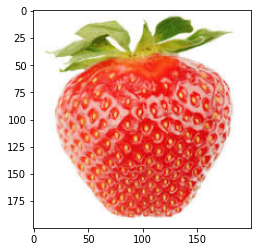

In [9]:
show_example(*dataset[0])


Label:  O (0)


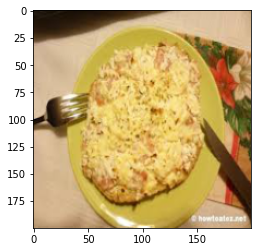

In [10]:
show_example(*dataset[10000])

Label:  R (1)


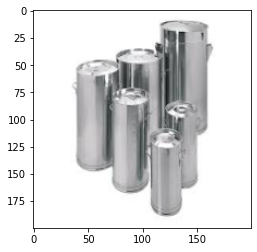

In [11]:
show_example(*dataset[17000])

Label:  R (1)


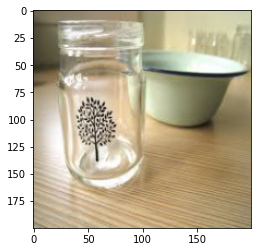

In [12]:
show_example(*dataset[17500])

# Training and Validation Set

In [13]:
random_seed = 42
torch.manual_seed(random_seed);
val_size = 5000
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(17564, 5000)

In [14]:
from torch.utils.data.dataloader import DataLoader
batch_size=50

In [15]:
train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)

In [16]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

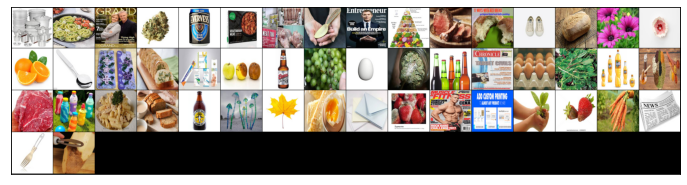

In [17]:
show_batch(train_dl)

In [18]:
import torch.nn as nn
import torch.nn.functional as F

In [19]:
simple_model = nn.Sequential(
    nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
    nn.MaxPool2d(2, 2)
)

In [20]:
for images, labels in train_dl:
    print('images.shape:', images.shape)
    out = simple_model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([50, 3, 200, 200])
out.shape: torch.Size([50, 8, 100, 100])


In [21]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [22]:
class WasteManagementModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            # input: 3 x 200 x 200
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            # 32 x 200 x 200
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            # 64 x 200 x 200
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 100 x 100 
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2), # 64 * 50  * 50
            nn.MaxPool2d(2,2), # 64 * 25 * 25

            nn.Flatten(), 
            nn.Linear(64*25*25, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU(),
            nn.Linear(10,2))
        
    def forward(self, xb):
        return self.network(xb)

In [23]:
model=WasteManagementModel()

In [24]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)
      

In [25]:
device = get_default_device()
device

device(type='cuda')

In [26]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

# Training the Model

In [27]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [28]:
model = to_device(WasteManagementModel(), device)

In [29]:
evaluate(model, val_dl)

{'val_acc': 0.5615999698638916, 'val_loss': 0.6875912547111511}

In [30]:
num_epochs = 5
opt_func = torch.optim.Adam
lr = 0.001

In [31]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 0.4328, val_loss: 0.4550, val_acc: 0.8006
Epoch [1], train_loss: 0.3443, val_loss: 0.3538, val_acc: 0.8474
Epoch [2], train_loss: 0.3093, val_loss: 0.3408, val_acc: 0.8540
Epoch [3], train_loss: 0.2797, val_loss: 0.3442, val_acc: 0.8478
Epoch [4], train_loss: 0.2329, val_loss: 0.3447, val_acc: 0.8544


In [32]:
num_epochs = 5
lr = 0.0001

In [33]:
history = fit(num_epochs, lr, model, train_dl, val_dl)

Epoch [0], train_loss: 0.1736, val_loss: 0.3254, val_acc: 0.8692
Epoch [1], train_loss: 0.1642, val_loss: 0.3255, val_acc: 0.8698
Epoch [2], train_loss: 0.1595, val_loss: 0.3270, val_acc: 0.8702
Epoch [3], train_loss: 0.1561, val_loss: 0.3284, val_acc: 0.8702
Epoch [4], train_loss: 0.1529, val_loss: 0.3306, val_acc: 0.8696


In [34]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

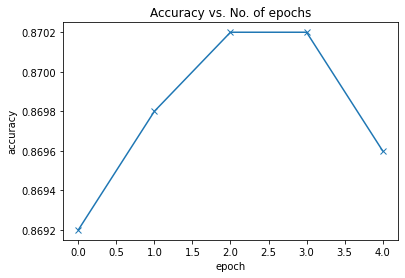

In [35]:
plot_accuracies(history)

In [36]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

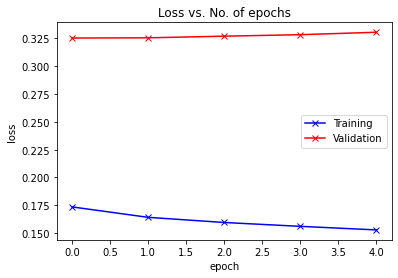

In [37]:
plot_losses(history)

# Testing on Test Data

In [38]:
test_dataset = ImageFolder(data_dir+'/TEST',transforms)
len(test_dataset)

2513

In [39]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

Label: O , Predicted: O


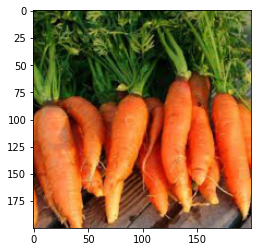

In [40]:
img, label = test_dataset[0]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: O , Predicted: O


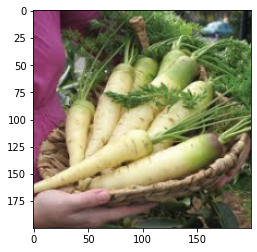

In [41]:
img, label = test_dataset[100]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: R , Predicted: O


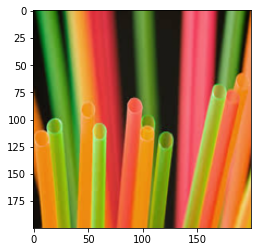

In [42]:
img, label = test_dataset[2000]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

Label: R , Predicted: R


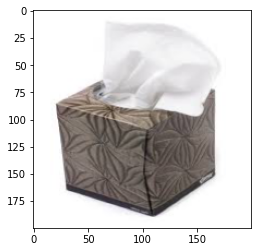

In [43]:
img, label = test_dataset[2500]
plt.imshow(img.permute(1, 2, 0))
print('Label:', dataset.classes[label], ', Predicted:', predict_image(img, model))

In [44]:
test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size*2), device)
result = evaluate(model, test_loader)
result

{'val_acc': 0.8848521709442139, 'val_loss': 0.3103417754173279}

In [45]:
torch.save(model.state_dict(), 'waste-management-cnn.pth')

In [46]:
!pip install jovian 
import jovian 

TypeError: ignored

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: ··········
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/harshghodkar/waste-management


'https://jovian.ai/harshghodkar/waste-management'